In [1]:
%load_ext autoreload
%autoreload 2

### Extract attn weights from the models - use `uni` env

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
os.chdir("../..")

DATA_DIR = os.environ["DATA_DIR"]
OUTPUT_DIR = os.environ["OUTPUT_DIR"]

In [3]:
import pickle

import torch
from transformers import AutoModel

from models.agg import MILClassifier

/home/sjne/miniconda3/envs/uni/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
gigapath_best_model = os.path.join(
    OUTPUT_DIR, "chkpts/gigapath/gigapath-abmil-1_head-fold-1.pt"
)
uni_best_model = os.path.join(
    OUTPUT_DIR, "chkpts/uni/uni-abmil-1_head-fold-3.pt"
)
prism_local_model = os.path.join(
    OUTPUT_DIR,
    "..",
    "models/models--paige-ai--Prism/snapshots/cd2eae7b1e6e51f3664e1a575c5bfe7045cc37d4",
)
resnet_best_model = os.path.join(
    OUTPUT_DIR, "chkpts/resnet18/resnet18-gabmil-8_heads-fold-3.pt"
)
hf_cache_dir = os.path.join(OUTPUT_DIR, "../models")
tile_embeddings_dir = os.path.join(
    OUTPUT_DIR, "{foundation_model}/tile_embeddings_sorted"
)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


def load_model(model_name):
    if model_name == "uni":
        model = MILClassifier(1024, 4, 1, False).to(device)
        model.load_state_dict(torch.load(uni_best_model))
    elif model_name == "gigapath":
        model = MILClassifier(1536, 4, 1, False).to(device)
        model.load_state_dict(torch.load(gigapath_best_model))
    elif model_name == "resnet18":
        model = MILClassifier(512, 4, 8, True).to(device)
        model.load_state_dict(torch.load(resnet_best_model))
    else:
        model = AutoModel.from_pretrained(
            prism_local_model,
            cache_dir=hf_cache_dir,
            trust_remote_code=True,
        )
    return model

cuda


In [6]:
def get_weights(model, model_name, slide_id):
    with open(
        os.path.join(
            tile_embeddings_dir.format(foundation_model=model_name),
            f"{slide_id}.pkl",
        ),
        "rb",
    ) as f:
        tile_embeddings = pickle.load(f)

    # tile_coords = []
    # for coords in tile_embeddings["coords"]:
    #     tile_coords.append({"x": int(coords[0]), "y": int(coords[1])})

    model.to(device)

    if model_name == "prism":
        with torch.autocast("cuda", torch.float16), torch.inference_mode():
            out = model.slide_representations(
                tile_embeddings=tile_embeddings["tile_embeds"]
                .float()
                .unsqueeze(0)
                .to(device)
            )
            weights = (
                out["xattn_weights"].squeeze().max(dim=0).values.detach().cpu()
            ).numpy()
    else:
        with torch.inference_mode():
            _, weights = model(
                tile_embeddings["tile_embeds"].unsqueeze(0).to(device),
                tile_embeddings["pos"].unsqueeze(0).to(device),
            )
            if model_name == "resnet18":
                weights = weights.view(8, -1)
                weights = weights.mean(dim=0)
            weights = weights.squeeze().detach().cpu().numpy()

    return weights, tile_embeddings["coords"].tolist()

In [7]:
slide_ids = ["660369-6", "660524-2", "660109-1", "660375-1"]
models = ["prism", "uni", "gigapath"]

for m in models:
    for slide_id in slide_ids:
        model = load_model(m)
        weights, coords = get_weights(model, m, slide_id)
        with open(
            os.path.join(
                OUTPUT_DIR, f"attn-heatmaps/weights/{m}-{slide_id}-weights.pkl"
            ),
            "wb",
        ) as f:
            pickle.dump(
                {
                    "weights": weights,
                    "coords": coords,
                },
                f,
            )

BioGptForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/home/sjne/miniconda3/envs/uni/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not se

### Plot the heatmaps - use `gigapath` env

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
os.chdir("../..")

DATA_DIR = os.getenv("DATA_DIR")
OUTPUT_DIR = os.getenv("OUTPUT_DIR")

In [3]:
import pickle

from gigapath.preprocessing.data.foreground_segmentation import LoadROId
from matplotlib import collections, patches, pyplot as plt
from monai.data.wsi_reader import WSIReader
import numpy as np

from data_processing.slide_utils import plot_image

%matplotlib inline

/home/sjne/miniconda3/envs/gigapath_clone/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


processing 660369-6 for prism


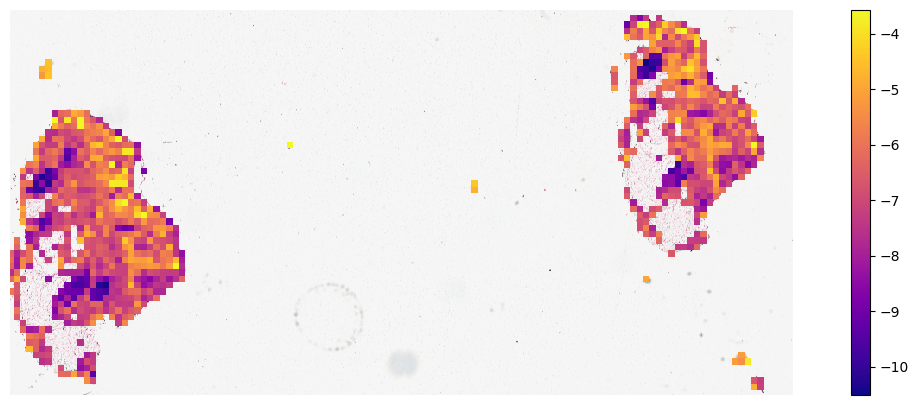

processing 660524-2 for prism


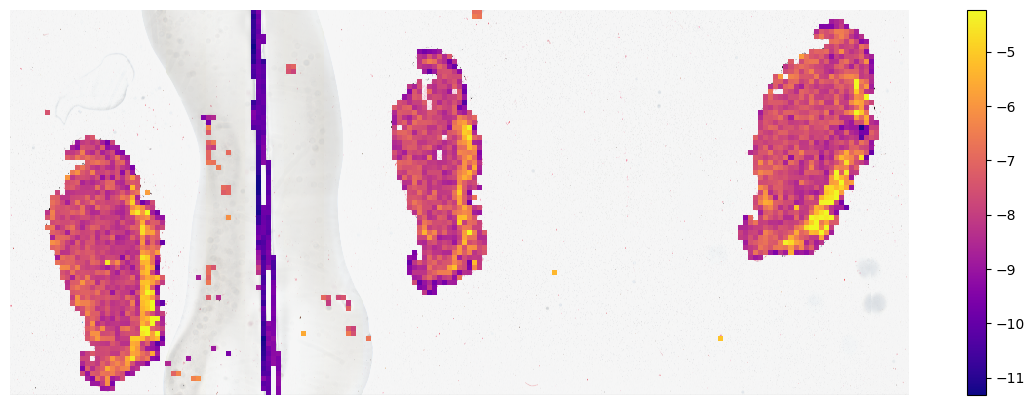

processing 660109-1 for prism


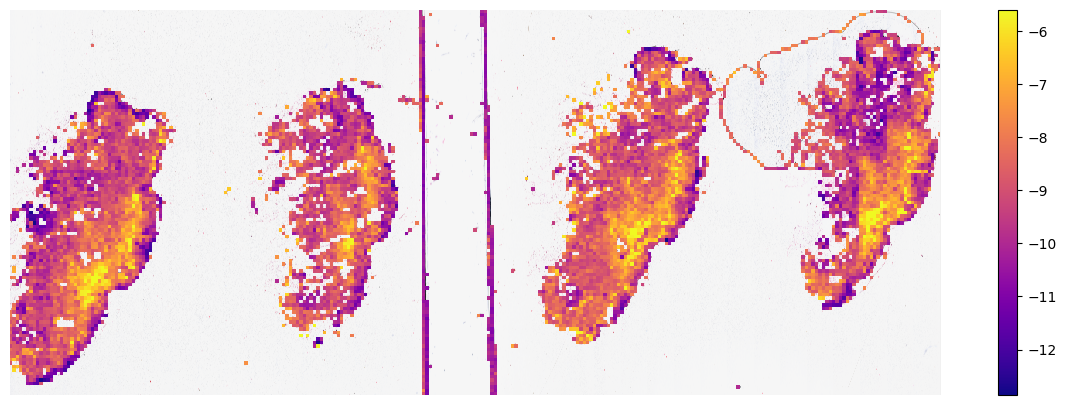

processing 660375-1 for prism


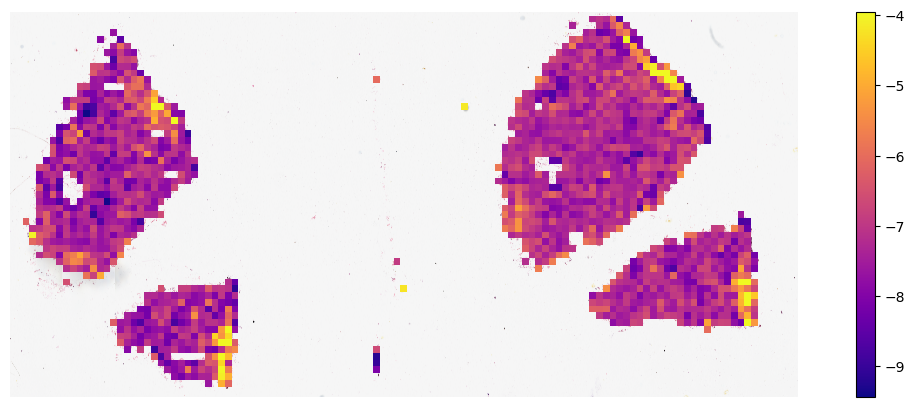

processing 660369-6 for uni


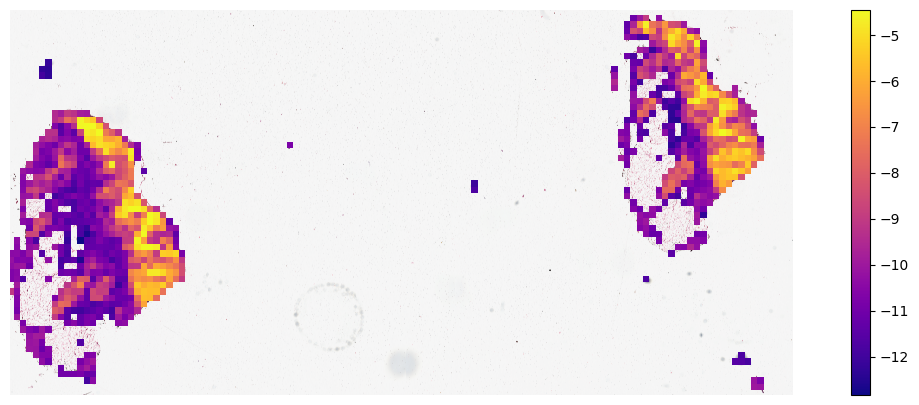

processing 660524-2 for uni


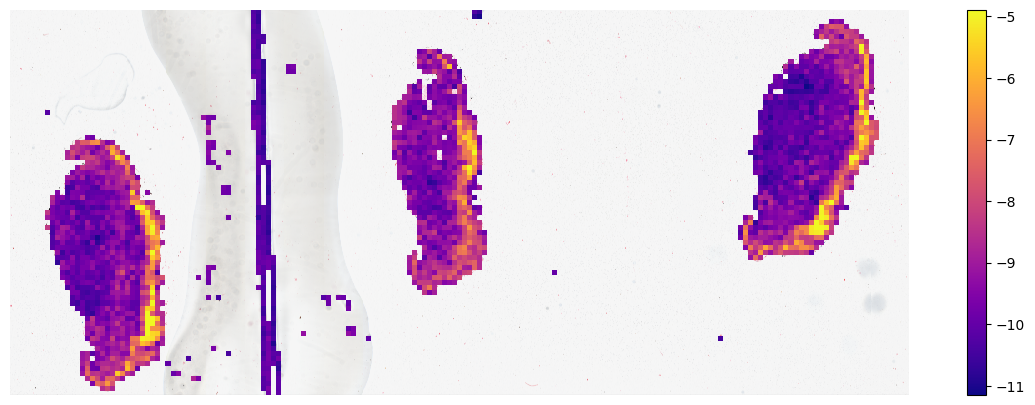

processing 660109-1 for uni


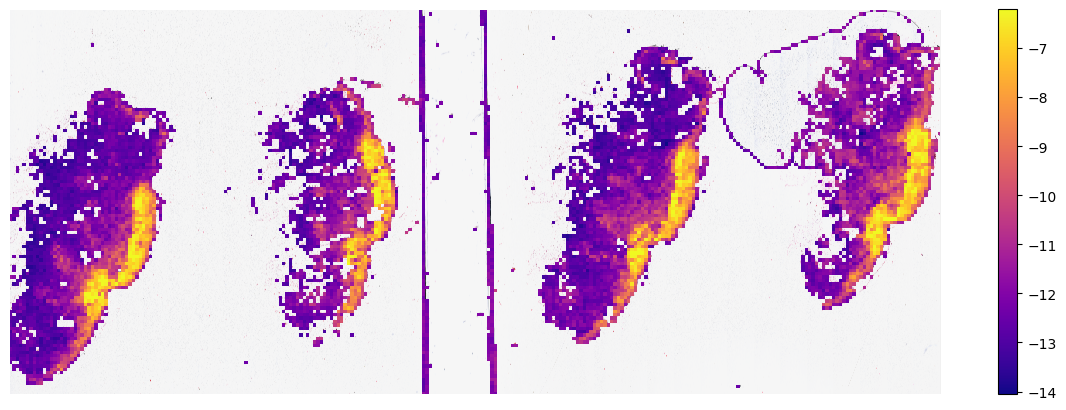

processing 660375-1 for uni


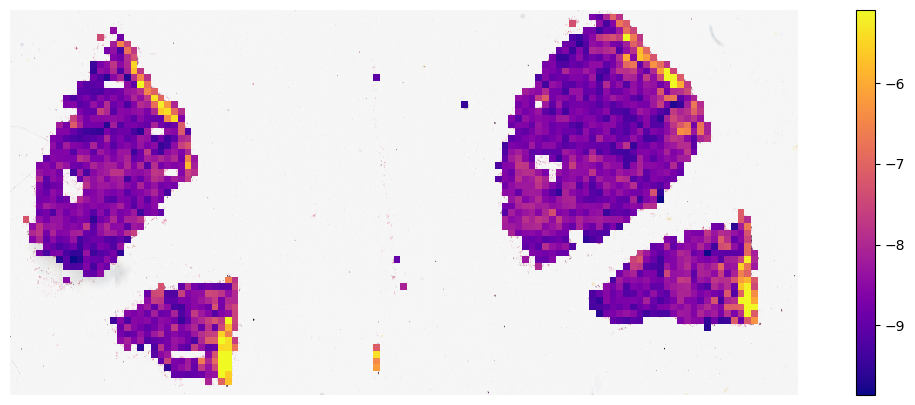

processing 660369-6 for gigapath


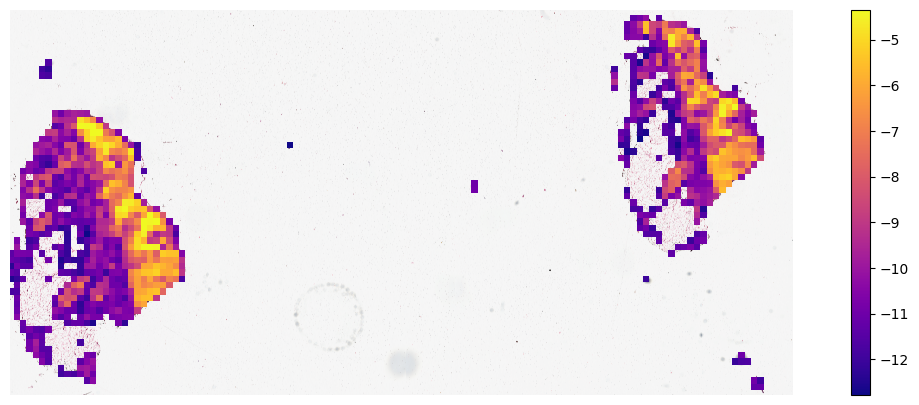

processing 660524-2 for gigapath


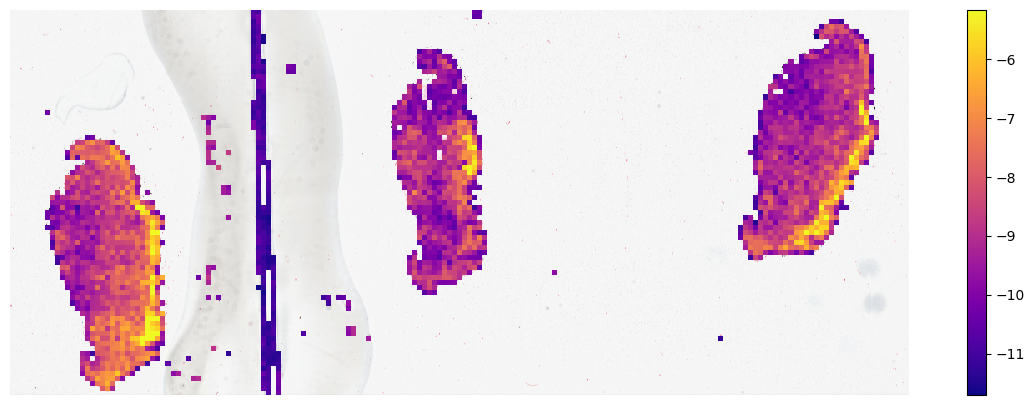

processing 660109-1 for gigapath


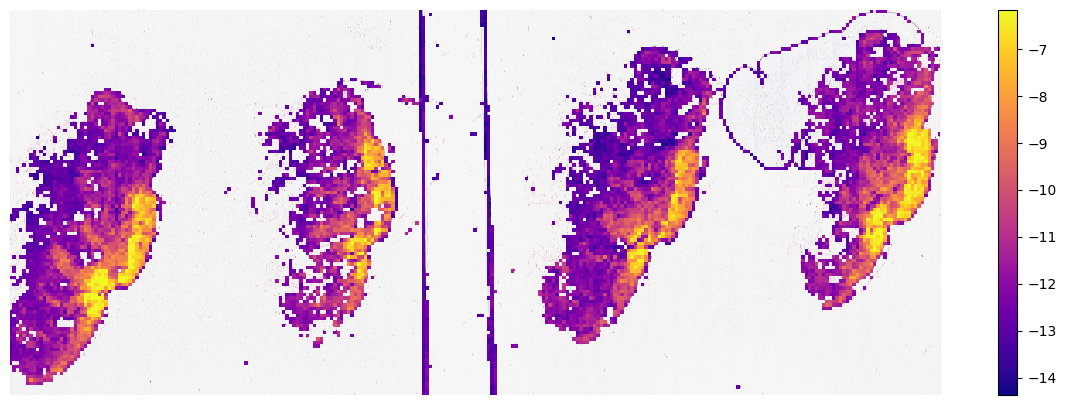

processing 660375-1 for gigapath


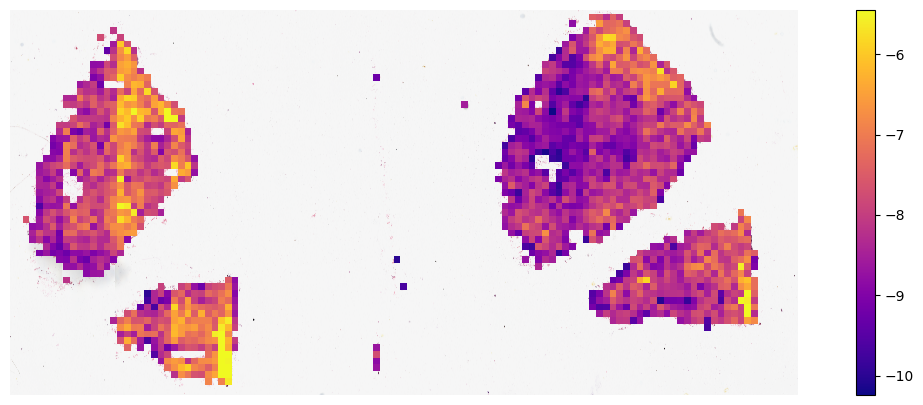

In [5]:
slide_ids = ["660369-6", "660524-2", "660109-1", "660375-1"]
models = ["prism", "uni", "gigapath"]

vmin = {}
vmax = {}
coords = None
for slide_id in slide_ids:
    weights_dict = {}
    weights = []
    for m in models:
        with open(
            os.path.join(
                OUTPUT_DIR, f"attn-heatmaps/weights/{m}-{slide_id}-weights.pkl"
            ),
            "rb",
        ) as f:
            data = pickle.load(f)
            coords = data["coords"]

            # clip weights to control for outliers
            min_threshold = np.percentile(data["weights"], 0)
            max_threshold = np.percentile(data["weights"], 99)
            clipped_scores = np.clip(
                data["weights"], min_threshold, max_threshold
            )

            weights_dict[m] = clipped_scores
            weights.append(clipped_scores)

    vmin[slide_id] = np.log(np.array(weights)).min()
    vmax[slide_id] = np.log(np.array(weights)).max()

    for m in models:
        with open(
            os.path.join(
                OUTPUT_DIR,
                f"attn-heatmaps/weights/{m}-{slide_id}-weights-clipped.pkl",
            ),
            "wb",
        ) as f:
            pickle.dump(
                {
                    "weights": weights_dict[m],
                    "coords": coords,
                },
                f,
            )

for m in models:
    for slide_id in slide_ids:
        print(f"processing {slide_id} for {m}")
        image_path = os.path.join(DATA_DIR, f"slides/{slide_id}.svs")
        with open(
            os.path.join(
                OUTPUT_DIR,
                f"attn-heatmaps/weights/{m}-{slide_id}-weights-clipped.pkl",
            ),
            "rb",
        ) as f:
            data = pickle.load(f)

        weights = np.log(data["weights"])
        fig, ax = plt.subplots(figsize=(15, 5))
        plot_image(image_path, ax, data["coords"], np.log(data["weights"]))
        plt.show()
        plt.close()